# Project1 - Group 4


### Library dependencies

In [157]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import requests
# import time
# from scipy.stats import linregress
# import datetime

from os import listdir
from os.path import isfile, join
# Reference: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

# Data sources - load, consolidate, and merge

In [158]:
# Paths to analysis data files:
# Uber trips files from Kaggle
uber2014_path = join("data", "kaggle_csv", "uber-raw-data-2014")
# New York city Weather for months corresponding to the Uber trips
noaa2014_path = "data/noaa_csv/2014"

### Consolidate Uber trips data

In [159]:
# Read the Uber trips data and consolidate into one file
# Uber trips files from Kaggle
uber2014 = pd.DataFrame()
files = [join(uber2014_path, f) for f in listdir(uber2014_path) if isfile(join(uber2014_path, f))]
for f in files:
    data = pd.read_csv(f)
    if (len(uber2014)) == 0:    
        uber2014 = data.copy(deep=True)
    else:
        combined = pd.concat([uber2014, data], axis=0, ignore_index=True)
        uber2014 = combined.copy(deep=True)

In [160]:
# Check for and remove duplicate rows
uber2014 = uber2014.drop_duplicates()

In [161]:
# Convert from US-format date, and split orginal datetime into Date and Time columns
uber2014["DateTime"] = pd.to_datetime(uber2014["Date/Time"], format='%m/%d/%Y %H:%M:%S')
uber2014["Date"] = uber2014["DateTime"].dt.normalize()
uber2014 = uber2014[["Date", "DateTime", "Lat", "Lon", "Base"]]

In [162]:
# Write out the combined dataset
uber2014.to_csv(join("data", "combined", "uber-combined-data-2014.csv"), encoding = "UTF-8", index=False)
print(f"Total unique rows (Uber rides 2014 data): {len(uber2014)}")

Total unique rows (Uber rides 2014 data): 4451746


### Consolidate New York City weather data for the trips period (& convert to metric units)

In [163]:
# Formulas for conversion of temperature and rainfall to metric units
def Convert_Fahrenheit_to_Celsius(deg_F):
    deg_C = (deg_F - 32) / (9/5)
    return deg_C

def Inches_to_Millimetres(inches):
    millimetres = inches * 25.4
    return millimetres

In [164]:
# Read the Weather data, convert to metric units, and consolidate into one file
# Uber trips files from NOAA
weather2014 = pd.DataFrame()
files = [join(noaa2014_path, f) for f in listdir(noaa2014_path) if isfile(join(noaa2014_path, f))]
for f in files:
    data = pd.read_csv(f)
    if (len(weather2014)) == 0:    
        weather2014 = data.copy(deep=True)
    else:
        combined = pd.concat([weather2014, data], axis=0, ignore_index=True)
        weather2014 = combined.copy(deep=True)
        
# Fix column names to remove newlines introduced by 'word wrap' in CSV file header
weather2014.columns = ["Year", "Month", "Day", "MaxTemp_(degF)", "MinTemp_(degF)", "Rain_MeltedSnow_Etc_(in)", "Snow_IcePellets_Hail_(in)", "Snow_IcePellets_Hail_IceOnGround_(in)"]

# We want to keep the 24-hour observation values only, so drop the "Snow_IcePellets_Hail_IceOnGround_(in)" column as that represented 'at observation time' data.
weather2014 = weather2014[["Year", "Month", "Day", "MaxTemp_(degF)", "MinTemp_(degF)", "Rain_MeltedSnow_Etc_(in)", "Snow_IcePellets_Hail_(in)"]]

# Combine Year-Month-Day columns for form a date value in yyyy-mm-dd format
weather2014["Date"] = pd.to_datetime(dict(year=weather2014.Year, month=weather2014.Month, day=weather2014.Day))

# Convert temperature and rainfall to metric units
weather2014["MaxTemp_degC"] = weather2014["MaxTemp_(degF)"].apply(Convert_Fahrenheit_to_Celsius).round(3)
weather2014["MinTemp_degC"] = weather2014["MinTemp_(degF)"].apply(Convert_Fahrenheit_to_Celsius).round(3)
weather2014["Rain_MeltedSnow_Etc_mm"] = weather2014["Rain_MeltedSnow_Etc_(in)"].apply(Inches_to_Millimetres).round(3)
weather2014["Snow_IcePellets_Hail_mm"] = weather2014["Snow_IcePellets_Hail_(in)"].apply(Inches_to_Millimetres).round(3)

# Combine Rain & Snow readings into single 'Precipitation' value
weather2014["Precipitation_mm"] = weather2014["Rain_MeltedSnow_Etc_mm"] + weather2014["Snow_IcePellets_Hail_mm"]

# Keep just the metric values
weather2014 = weather2014[["Date", "MaxTemp_degC", "MinTemp_degC", "Precipitation_mm"]]

# Write out combined data with metric units
weather2014.to_csv(join("data", "combined", "weather-combined-data-metric-2014.csv"), encoding = "UTF-8", index=False)


## Merge Uber trips and Weather data

In [165]:
# Merge the Uber data with the Weather data on the Date column
Uber_Weather_df = pd.merge(uber2014, weather2014, on="Date", how='left')

# Display the first few rows of the merged DataFrame
Uber_Weather_df.head()

,Date,DateTime,Lat,Lon,Base,MaxTemp_degC,MinTemp_degC,Precipitation_mm
0,2014-04-01,2014-04-01 00:11:00,40.7690,-73.9549,B02512,15.556,3.889,0.0
1,2014-04-01,2014-04-01 00:17:00,40.7267,-74.0345,B02512,15.556,3.889,0.0
2,2014-04-01,2014-04-01 00:21:00,40.7316,-73.9873,B02512,15.556,3.889,0.0
3,2014-04-01,2014-04-01 00:28:00,40.7588,-73.9776,B02512,15.556,3.889,0.0
4,2014-04-01,2014-04-01 00:33:00,40.7594,-73.9722,B02512,15.556,3.889,0.0


In [166]:
# Cross check the number of rows
num_rows = len(Uber_Weather_df)
print(f"Number of rows in Uber_Weather_merged_data: {num_rows:,}")

Number of rows in Uber_Weather_merged_data: 4,451,746


# Exploratory Data Analysis

In [167]:
# Assign categorical flag to the dataset, to define three groups: cold (0), mild (1), and hot (2) temperatures
Uber_Weather_df["TempBand"] = Uber_Weather_df["MaxTemp_degC"].apply(lambda t: "cold" if t < 10 else ("mild" if (t >= 10 and t <= 25) else "hot") )
#TempBand_DisplayOrder = [0, 1, 2]
#Uber_Weather_df["TempBand_DisplayOrder"] = Uber_Weather_df["MaxTemp_degC"].apply(lambda t: "0" if t < 10 else ("1" if (t >= 10 and t <= 25) else "2") )

# Uber_Weather_df["Precipitation_YN"] = Uber_Weather_df["Precipitation"].apply(lambda t: "cold" if t < 10 else ("mild" if (t >= 10 and t <= 25) else "hot") )

Uber_Weather_df.head()

# Split data set into three groups: cold, mild, and warm temperatures


,Date,DateTime,Lat,Lon,Base,MaxTemp_degC,MinTemp_degC,Precipitation_mm,TempBand
0,2014-04-01,2014-04-01 00:11:00,40.7690,-73.9549,B02512,15.556,3.889,0.0,mild
1,2014-04-01,2014-04-01 00:17:00,40.7267,-74.0345,B02512,15.556,3.889,0.0,mild
2,2014-04-01,2014-04-01 00:21:00,40.7316,-73.9873,B02512,15.556,3.889,0.0,mild
3,2014-04-01,2014-04-01 00:28:00,40.7588,-73.9776,B02512,15.556,3.889,0.0,mild
4,2014-04-01,2014-04-01 00:33:00,40.7594,-73.9722,B02512,15.556,3.889,0.0,mild


In [168]:
trips_df = Uber_Weather_df.groupby(["Date", "TempBand", "MaxTemp_degC", "Precipitation_mm"]).size().reset_index(name="Trips")

trips_df.head()


#trips = trips_grp.reset_index()

#trips.head()

#mild_trips = trips_grp[ Uber_Weather_df["TempBand"] == "mild" ]

#mild_trips.head()

,Date,TempBand,MaxTemp_degC,Precipitation_mm,Trips
0,2014-04-01,mild,15.556,0.000,14376
1,2014-04-02,mild,12.222,0.000,17230
2,2014-04-03,mild,19.444,1.778,20482
3,2014-04-04,cold,8.333,5.334,26353
4,2014-04-05,mild,12.222,0.000,19273


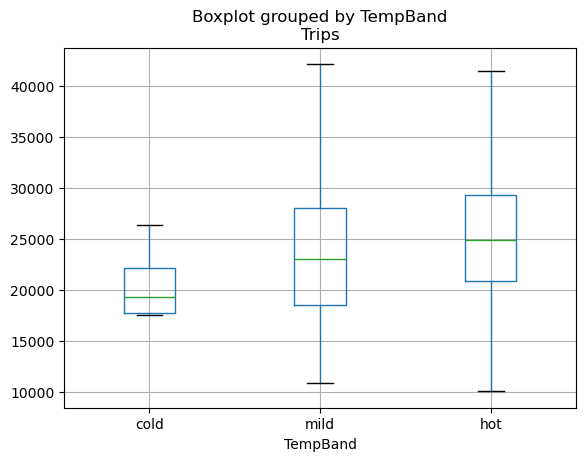

In [154]:
ax = trips_df.boxplot("Trips", by="TempBand", positions=[0, 2, 1])

<Axes: xlabel='TempBand', ylabel='Trips'>

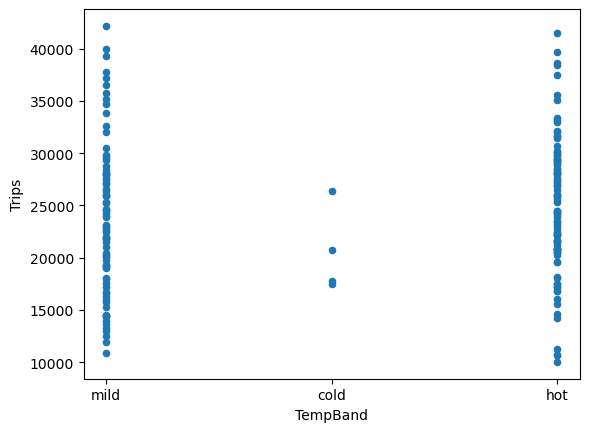

In [153]:
trips_df.plot(kind='scatter', x="TempBand", y="Trips", legend=False)

<Axes: xlabel='MaxTemp_degC', ylabel='Trips'>

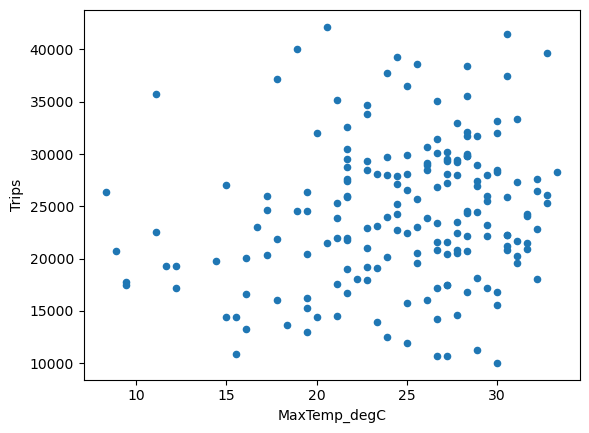

In [152]:
trips_df.plot(kind='scatter', x="MaxTemp_degC", y="Trips", legend=False)

<Axes: xlabel='Date', ylabel='MaxTemp_degC'>

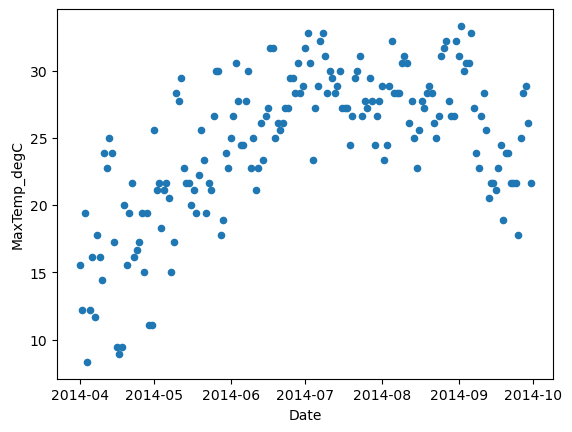

In [151]:
trips_df.plot(kind='scatter', x="Date", y="MaxTemp_degC", legend=False)

<Axes: xlabel='Date', ylabel='Trips'>

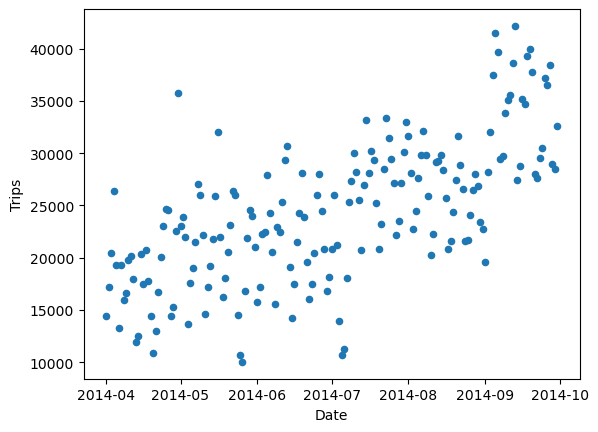

In [150]:
trips_df.plot(kind='scatter', x="Date", y="Trips", legend=False)

In [122]:
Uber_Weather_grp = Uber_Weather_df.groupby("TempBand")

# Uber_Weather_grp["MaxTemp_degC"].count()
# tmp = pd.DataFrame(Uber_Weather_grp["MaxTemp_degC"].count())

tmp = pd.DataFrame(Uber_Weather_grp["Trips"].count())
tmp

,Trips
TempBand,
cold,82346
hot,2399431
mild,1969969


In [56]:
# Uber_Weather_grp = Uber_Weather_df.groupby(["TempBand", "TempBand_DisplayOrder"])
# #Uber_Weather_grp = Uber_Weather_df.groupby(["TempBand"])
# #Uber_Weather_grp[["MaxTemp_degC"].count()
# Uber_Weather_grp["MaxTemp_degC"].count()#.sort_values(["TempBand_DisplayOrder"])
# #type(Uber_Weather_grp["MaxTemp_degC"].count())
# tmp = pd.DataFrame(Uber_Weather_grp["MaxTemp_degC"].count())
# tmp

,,MaxTemp_degC
TempBand,TempBand_DisplayOrder,
cold,0,82346
hot,2,2399431
mild,1,1969969


# Statistical Analysis

### REVISIT: describe Null & Alternative Hypothesis (1)

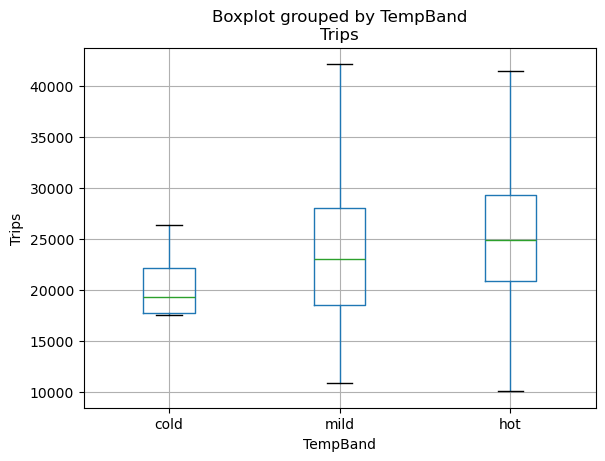

In [171]:
# Create a boxplot to compare means
ax = trips_df.boxplot("Trips", by="TempBand", positions=[0, 2, 1])
ax.set_ylabel("Trips")
plt.show()

# Other Exploratory Data Analysis